# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_311766/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_311766/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_311766/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-01 15:53:50,332] A new study created in RDB with name: no-name-75db8f67-3725-43d6-a06c-edad16daf162
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:618: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: 

  0%|          | 1/2000 [00:02<1:13:09,  2.20s/it]

tensor(1.4482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.456375002861023
current_loss: tensor(1.4444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4513379335403442
current_loss: tensor(1.4406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4336957931518555
current_loss: 

  0%|          | 6/2000 [00:02<09:24,  3.53it/s]  

tensor(1.4268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4226197004318237
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4241909980773926
current_loss: tensor(1.4117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4242784976959229
current_loss: tensor(1.4108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<10:52,  3.05it/s]


current_loss_val:  1.4237093925476074
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4227368831634521
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.423000693321228
Early Stop at iteration 8 with minimal loss tensor(1.4226, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<08:39,  3.85it/s]

current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.394515037536621
current_loss: tensor(1.3832, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.3341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3243484497070312
current_loss: tensor(1.3341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2990305423736572
current_loss: tensor(1.3124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3177, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.3048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2910804748535156
current_loss: tensor(1.3048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2893781661987305
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:32,  9.35it/s]

current_loss_val:  1.284628987312317
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.279809594154358
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755305767059326
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679368257522583
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:28,  9.52it/s]

current_loss_val:  1.2679648399353027
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640645503997803
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262162446975708
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606748342514038
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596049308776855


  1%|          | 16/2000 [00:01<03:25,  9.65it/s]

current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594245672225952
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259158968925476
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:20,  9.90it/s]

current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259220838546753
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593183517456055
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:45,  8.78it/s]

current_loss_val:  1.2604752779006958
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595945596694946
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259177327156067
Early Stop at iteration 20 with minimal loss tensor(1.2592, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:02,227] Trial 0 finished with value: -2.518317699432373 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.257281204951791, 'penalty_decorrelation_ridge_second_difference': 6.537206021442547}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.3033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613264322280884
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641938924789429
current_loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:24,  9.78it/s]

current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684969902038574
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677072286605835
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 5/2000 [00:00<04:03,  8.21it/s]


tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679067850112915
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685432434082031
Early Stop at iteration 5 with minimal loss tensor(1.2613, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:03,474] Trial 1 finished with value: -2.5226528644561768 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.16608073380425, 'penalty_decorrelation_ridge_second_difference': 10.157617836094246}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:25,  9.73it/s]

current_loss: tensor(1.2982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610676288604736
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631725072860718
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:15, 10.23it/s]

current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667521238327026
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665640115737915
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:07,  8.07it/s]

current_loss_val:  1.2677761316299438
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674899101257324
Early Stop at iteration 5 with minimal loss tensor(1.2611, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:04,775] Trial 2 finished with value: -2.522135019302368 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.406998041928244, 'penalty_decorrelation_ridge_second_difference': 10.657880032964133}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<04:24,  7.55it/s]

current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605537176132202
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27140212059021


  0%|          | 3/2000 [00:00<03:28,  9.56it/s]

current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267911672592163
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266907811164856
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:04,  8.15it/s]

current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644124031066895
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647669315338135
Early Stop at iteration 5 with minimal loss tensor(1.2606, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:06,075] Trial 3 finished with value: -2.5211074352264404 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.183837098025723, 'penalty_decorrelation_ridge_second_difference': 0.33272236729192695}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 2/2000 [00:00<03:14, 10.30it/s]

current_loss: tensor(1.3025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616751194000244
current_loss: tensor(1.3003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609961032867432
current_loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.28it/s]

current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608641386032104
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610929012298584
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:32,  9.38it/s]

current_loss_val:  1.2633445262908936
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650560140609741
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:52,  8.56it/s]


current_loss_val:  1.2663291692733765
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670530080795288
Early Stop at iteration 7 with minimal loss tensor(1.2609, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:07,627] Trial 4 finished with value: -2.521728515625 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.526583495734757, 'penalty_decorrelation_ridge_second_difference': 27.966347843339122}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 2/2000 [00:00<03:22,  9.89it/s]

current_loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609771490097046
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27015221118927
current_loss: tensor(1.2910, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:16, 10.14it/s]

current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267192006111145
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266923427581787
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:55,  8.49it/s]


current_loss_val:  1.2646687030792236
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654750347137451
Early Stop at iteration 5 with minimal loss tensor(1.2610, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:08,880] Trial 5 finished with value: -2.521953821182251 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.002893745294664, 'penalty_decorrelation_ridge_second_difference': 3.7542138787823696}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:37,  9.20it/s]

current_loss: tensor(1.3070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615786790847778
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639082670211792
current_loss: tensor(1.2919, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:18, 10.06it/s]

current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685203552246094
current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681684494018555
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:56,  8.42it/s]

current_loss_val:  1.2692216634750366
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692444324493408
Early Stop at iteration 5 with minimal loss tensor(1.2616, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:10,109] Trial 6 finished with value: -2.5231571197509766 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.499560642229767, 'penalty_decorrelation_ridge_second_difference': 12.07802375401199}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 2/2000 [00:00<03:13, 10.34it/s]

current_loss: tensor(1.3276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620235681533813
current_loss: tensor(1.3155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263428807258606
current_loss: tensor(1.3061, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:12, 10.36it/s]

current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658486366271973
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690603733062744
current_loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:50,  8.65it/s]


current_loss_val:  1.2720154523849487
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713525295257568
Early Stop at iteration 5 with minimal loss tensor(1.2620, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:11,368] Trial 7 finished with value: -2.524047374725342 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.68122519685501, 'penalty_decorrelation_ridge_second_difference': 23.80781853707821}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 2/2000 [00:00<03:14, 10.29it/s]

current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599871158599854
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618330717086792
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:11, 10.44it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262800693511963
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262388825416565
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:51,  8.63it/s]


current_loss_val:  1.261474370956421
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614738941192627
Early Stop at iteration 5 with minimal loss tensor(1.2600, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:12,636] Trial 8 finished with value: -2.5199742317199707 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.523721893309112, 'penalty_decorrelation_ridge_second_difference': 3.738453881501172}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:22,  9.87it/s]

current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605478763580322
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610341310501099
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:17, 10.11it/s]

current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627984285354614
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636027336120605
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:55,  8.48it/s]

current_loss_val:  1.2661511898040771
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652591466903687
Early Stop at iteration 5 with minimal loss tensor(1.2605, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:13,913] Trial 9 finished with value: -2.5210957527160645 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.925444666099692, 'penalty_decorrelation_ridge_second_difference': 12.637805028221148}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:25,  9.75it/s]

current_loss: tensor(1.3159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619006633758545
current_loss: tensor(1.3041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2727090120315552
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:16, 10.17it/s]

current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271868348121643
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709382772445679
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:07,  8.05it/s]

current_loss_val:  1.26889967918396
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684121131896973
Early Stop at iteration 5 with minimal loss tensor(1.2619, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:15,158] Trial 10 finished with value: -2.523801326751709 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.475040946182514, 'penalty_decorrelation_ridge_second_difference': 3.9727516772843483}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(1.3175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262027382850647
current_loss: tensor(1.3050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707840204238892
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:12, 10.37it/s]

current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2728776931762695
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711732387542725
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:53,  8.53it/s]

current_loss_val:  1.2686487436294556
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268876314163208
Early Stop at iteration 5 with minimal loss tensor(1.2620, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:16,413] Trial 11 finished with value: -2.524054765701294 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.89279985760631, 'penalty_decorrelation_ridge_second_difference': 5.258063612715702}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 2/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(1.3248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619801759719849
current_loss: tensor(1.3141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629926204681396


  0%|          | 4/2000 [00:00<03:17, 10.10it/s]

current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647231817245483
current_loss: tensor(1.2992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267507791519165
current_loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:57,  8.40it/s]


current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717949151992798
current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707332372665405
Early Stop at iteration 5 with minimal loss tensor(1.2620, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:17,665] Trial 12 finished with value: -2.5239598751068115 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.94726725166967, 'penalty_decorrelation_ridge_second_difference': 24.951707774957324}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:34,  9.34it/s]

current_loss: tensor(1.3000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611521482467651
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635509967803955
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673699855804443
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669724225997925
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:59,  8.32it/s]

current_loss_val:  1.2678169012069702
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679141759872437
Early Stop at iteration 5 with minimal loss tensor(1.2612, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:18,918] Trial 13 finished with value: -2.5223042964935303 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.36895262510344, 'penalty_decorrelation_ridge_second_difference': 10.4031172610752}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<04:26,  7.50it/s]

current_loss: tensor(1.3047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617158889770508
current_loss: tensor(1.2993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:27,  9.60it/s]

current_loss_val:  1.2616171836853027
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619378566741943
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629019021987915


  0%|          | 5/2000 [00:00<03:25,  9.70it/s]

current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266813039779663
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682121992111206
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:00,  8.31it/s]


current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677024602890015
Early Stop at iteration 6 with minimal loss tensor(1.2616, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:20,304] Trial 14 finished with value: -2.5232341289520264 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.3122748086772, 'penalty_decorrelation_ridge_second_difference': 22.459045849971744}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 2/2000 [00:00<03:11, 10.43it/s]

current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595996856689453
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602587938308716
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:35,  9.24it/s]

current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259734034538269
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2597277164459229
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:24,  7.53it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603317499160767
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606502771377563
Early Stop at iteration 5 with minimal loss tensor(1.2596, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:21,646] Trial 15 finished with value: -2.5191993713378906 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.0375816782815495, 'penalty_decorrelation_ridge_second_difference': 1.195061345464933}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596049308776855
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:26,  9.65it/s]

current_loss_val:  1.2596465349197388
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598451375961304
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602499723434448


  0%|          | 5/2000 [00:00<04:11,  7.94it/s]

current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260575294494629
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609713077545166
Early Stop at iteration 5 with minimal loss tensor(1.2596, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:22,929] Trial 16 finished with value: -2.519209623336792 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.0326973957378458, 'penalty_decorrelation_ridge_second_difference': 26.612338906659947}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:24,  9.79it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598923444747925
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595171928405762
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:16, 10.18it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596362829208374
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602170705795288
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:20,  9.96it/s]

current_loss_val:  1.2600383758544922


  0%|          | 6/2000 [00:00<05:04,  6.55it/s]

current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607388496398926
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<05:15,  6.32it/s]


current_loss_val:  1.260435938835144
Early Stop at iteration 6 with minimal loss tensor(1.2595, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:24,591] Trial 17 finished with value: -2.5190341472625732 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.2122052974325808, 'penalty_decorrelation_ridge_second_difference': 13.788480284425919}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 1/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601734399795532
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598440647125244
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:15, 10.22it/s]

current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600852251052856
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607554197311401
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:45,  8.86it/s]

current_loss_val:  1.2612583637237549
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635774612426758
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620614767074585
Early Stop at iteration 6 with minimal loss tensor(1.2598, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:25,969] Trial 18 finished with value: -2.5196878910064697 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.497515568482946, 'penalty_decorrelation_ridge_second_difference': 16.555358660052732}. Best is trial 0 with value: -2.518317699432373.
  0%|          | 2/2000 [00:00<03:15, 10.24it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596057653427124
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592365741729736
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:13, 10.30it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593121528625488
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259437918663025
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:13, 10.28it/s]

current_loss_val:  1.2589523792266846
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584810256958008
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257530689239502


  0%|          | 8/2000 [00:00<03:27,  9.61it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256845474243164
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:21,  9.86it/s]

current_loss_val:  1.2568918466567993
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568806409835815
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561736106872559


  1%|          | 12/2000 [00:01<03:28,  9.54it/s]

current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560205459594727
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:22,  9.82it/s]

current_loss_val:  1.2550573348999023
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545640468597412
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537072896957397


  1%|          | 17/2000 [00:01<03:18,  9.97it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2530384063720703
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516047954559326
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:32,  9.32it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505602836608887
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505625486373901
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:24,  9.67it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500206232070923
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24986732006073
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:20,  9.84it/s]

current_loss_val:  1.2503470182418823
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249465823173523
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493640184402466


  1%|▏         | 25/2000 [00:02<03:18,  9.97it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492856979370117
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499003410339355
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:15, 10.09it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249529480934143
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494367361068726
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:25,  9.58it/s]

current_loss_val:  1.2495625019073486
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498347759246826
Early Stop at iteration 29 with minimal loss tensor(1.2493, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:29,681] Trial 19 finished with value: -2.4985713958740234 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.38344039783605566, 'penalty_decorrelation_ridge_second_difference': 8.923023252520665}. Best is trial 19 with value: -2.4985713958740234.
  0%|          | 2/2000 [00:00<03:13, 10.31it/s]

current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259440541267395
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595086097717285
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2589040994644165
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258105754852295


  0%|          | 4/2000 [00:00<03:52,  8.60it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580095529556274
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578933238983154


  0%|          | 8/2000 [00:00<03:36,  9.20it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572829723358154
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255221962928772
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:31,  9.41it/s]

current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538790702819824
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252601146697998
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:28,  9.55it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526233196258545
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528115510940552
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:17, 10.07it/s]

current_loss_val:  1.2530882358551025
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252340316772461
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516947984695435


  1%|          | 17/2000 [00:01<03:14, 10.18it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251288890838623
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250396728515625
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:14, 10.20it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507073879241943
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506266832351685
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:13, 10.20it/s]

current_loss_val:  1.2503955364227295
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502703666687012
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:23,  9.70it/s]

current_loss_val:  1.2504867315292358
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504620552062988
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502859830856323


  1%|▏         | 25/2000 [00:02<03:20,  9.86it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507861852645874
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:33,  9.24it/s]


current_loss_val:  1.2504056692123413
Early Stop at iteration 25 with minimal loss tensor(1.2503, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:33,058] Trial 20 finished with value: -2.5005404949188232 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.11672614643758528, 'penalty_decorrelation_ridge_second_difference': 3.736033428632851}. Best is trial 19 with value: -2.4985713958740234.
  0%|          | 1/2000 [00:00<03:21,  9.94it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25959312915802
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593662738800049
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:15, 10.20it/s]

current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259473204612732
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595500946044922
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:14, 10.27it/s]

current_loss_val:  1.2583624124526978
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584936618804932
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587000131607056


  0%|          | 9/2000 [00:00<03:13, 10.28it/s]

current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257743000984192
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575112581253052
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:13, 10.27it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561697959899902
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561306953430176
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:14, 10.24it/s]

current_loss_val:  1.255272626876831
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540558576583862
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528595924377441


  1%|          | 15/2000 [00:01<03:13, 10.28it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512260675430298
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515640258789062
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:11, 10.36it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251129150390625
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508745193481445
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:09, 10.45it/s]

current_loss_val:  1.2508416175842285
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507046461105347
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505149841308594


  1%|          | 23/2000 [00:02<03:18,  9.94it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503236532211304
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250565767288208


  1%|          | 24/2000 [00:02<03:23,  9.70it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502169609069824
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501050233840942


  1%|▏         | 26/2000 [00:02<03:21,  9.80it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502622604370117
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498818635940552
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:18,  9.93it/s]

current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499650716781616
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500100135803223
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:15, 10.08it/s]

current_loss_val:  1.2499839067459106
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497848272323608
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:24,  9.63it/s]

current_loss_val:  1.249768853187561
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249614953994751
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:45,  8.70it/s]

current_loss_val:  1.2497137784957886
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249680519104004
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:31,  9.27it/s]

current_loss_val:  1.2493431568145752
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491596937179565
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482295036315918


  2%|▏         | 39/2000 [00:03<03:24,  9.58it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475330829620361
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:25,  9.53it/s]

current_loss_val:  1.2465605735778809
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468701601028442
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246460199356079


  2%|▏         | 44/2000 [00:04<03:19,  9.80it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464097738265991
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464570999145508
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:16,  9.95it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462656497955322
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246497392654419
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:04<03:30,  9.28it/s]

current_loss_val:  1.246368408203125
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463345527648926
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<03:24,  9.56it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463115453720093
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463487386703491
Early Stop at iteration 49 with minimal loss tensor(1.2463, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:38,930] Trial 21 finished with value: -2.4925310611724854 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2014136581219361, 'penalty_decorrelation_ridge_second_difference': 6.835176705630393}. Best is trial 21 with value: -2.4925310611724854.
  0%|          | 2/2000 [00:00<03:13, 10.35it/s]

current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595806121826172
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591968774795532
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:16, 10.18it/s]

current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592705488204956
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593811750411987
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:19, 10.01it/s]

current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588363885879517
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583624124526978
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:29,  9.52it/s]

current_loss_val:  1.2573633193969727
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564074993133545
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:23,  9.80it/s]

current_loss_val:  1.2564023733139038
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562837600708008
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557076215744019


  1%|          | 12/2000 [00:01<03:18, 10.00it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253932237625122
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535555362701416
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:26,  9.62it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528711557388306
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520049810409546
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:28,  9.51it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251052737236023
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506916522979736
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:25,  9.63it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503482103347778
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498433589935303
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:33,  9.26it/s]

current_loss_val:  1.2495925426483154
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249147891998291
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:26,  9.58it/s]

current_loss_val:  1.2491087913513184
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249009370803833
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490699291229248


  1%|▏         | 25/2000 [00:02<03:21,  9.79it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490891218185425
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:40,  8.93it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494585514068604
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494606971740723
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:35,  9.17it/s]


current_loss_val:  1.2496256828308105
Early Stop at iteration 27 with minimal loss tensor(1.2490, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:42,574] Trial 22 finished with value: -2.498018503189087 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.028868574310391554, 'penalty_decorrelation_ridge_second_difference': 8.816995346871117}. Best is trial 21 with value: -2.4925310611724854.
  0%|          | 2/2000 [00:00<03:15, 10.24it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259672999382019
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259252905845642
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:13, 10.31it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259303331375122
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594802379608154
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:15, 10.22it/s]

current_loss_val:  1.2590491771697998
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587356567382812
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581342458724976


  0%|          | 8/2000 [00:00<03:15, 10.18it/s]

current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593814134597778
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580323219299316
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576758861541748
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257263422012329
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 12/2000 [00:01<03:16, 10.11it/s]

tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572731971740723
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564749717712402
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:15, 10.17it/s]

current_loss_val:  1.2558867931365967
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255533218383789
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550712823867798
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541815042495728
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:23,  9.73it/s]

current_loss_val:  1.253955364227295
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537873983383179
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529217004776


  1%|          | 21/2000 [00:02<03:29,  9.43it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522739171981812
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:27,  9.53it/s]

current_loss_val:  1.2511388063430786
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250095248222351
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507390975952148


  1%|▏         | 25/2000 [00:02<03:37,  9.10it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499741315841675
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496520280838013
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:48,  8.64it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495110034942627
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501201629638672


  2%|▏         | 30/2000 [00:03<03:36,  9.11it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499271631240845
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498887777328491
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:31,  9.33it/s]


current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25003981590271
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249983787536621
Early Stop at iteration 31 with minimal loss tensor(1.2495, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:46,709] Trial 23 finished with value: -2.4990220069885254 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.23905788535539185, 'penalty_decorrelation_ridge_second_difference': 11.33959265861004}. Best is trial 21 with value: -2.4925310611724854.
  0%|          | 2/2000 [00:00<03:15, 10.23it/s]

current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601797580718994
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609273195266724
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.29it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614433765411377
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622805833816528
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:54,  8.50it/s]


current_loss_val:  1.2626533508300781
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635623216629028
Early Stop at iteration 5 with minimal loss tensor(1.2602, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:48,098] Trial 24 finished with value: -2.5203592777252197 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.50093505307331, 'penalty_decorrelation_ridge_second_difference': 8.823935075553493}. Best is trial 21 with value: -2.4925310611724854.
  0%|          | 1/2000 [00:00<03:24,  9.78it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596770524978638
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593152523040771
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:17, 10.11it/s]

current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593865394592285
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595860958099365
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:18, 10.03it/s]

current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259231686592102
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586965560913086
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:20,  9.94it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584630250930786
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586944103240967
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:17, 10.08it/s]

current_loss_val:  1.2583909034729004
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582995891571045
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:30,  9.44it/s]

current_loss_val:  1.2572791576385498
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571221590042114
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:21,  9.85it/s]

current_loss_val:  1.25675630569458
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564395666122437
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560863494873047


  1%|          | 16/2000 [00:01<03:21,  9.85it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551960945129395
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548383474349976
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:18,  9.96it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544375658035278
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542139291763306
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:16, 10.08it/s]

current_loss_val:  1.253853678703308
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253000259399414
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506678104400635


  1%|          | 24/2000 [00:02<03:14, 10.17it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250699520111084
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503349781036377
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:14, 10.17it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501497268676758
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507696151733398
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:14, 10.14it/s]

current_loss_val:  1.2504125833511353
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504634857177734
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510110139846802


  1%|▏         | 29/2000 [00:03<03:26,  9.56it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509722709655762
Early Stop at iteration 29 with minimal loss tensor(1.2501, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:51,882] Trial 25 finished with value: -2.5002989768981934 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0002581954376246, 'penalty_decorrelation_ridge_second_difference': 9.931815480560061}. Best is trial 21 with value: -2.4925310611724854.
  0%|          | 2/2000 [00:00<03:31,  9.45it/s]

current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600762844085693
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26064932346344


  0%|          | 4/2000 [00:00<03:26,  9.68it/s]

current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609870433807373
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616413831710815


  0%|          | 5/2000 [00:00<04:08,  8.04it/s]

current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617095708847046
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262192726135254
Early Stop at iteration 5 with minimal loss tensor(1.2601, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:53,163] Trial 26 finished with value: -2.5201523303985596 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.379825199123386, 'penalty_decorrelation_ridge_second_difference': 8.421827181195848}. Best is trial 21 with value: -2.4925310611724854.
  0%|          | 1/2000 [00:00<03:22,  9.89it/s]

current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608087062835693
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260370135307312
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603635787963867
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606672048568726
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:35,  9.23it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625927925109863
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636209726333618
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:57,  8.41it/s]


current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264046311378479
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643816471099854
Early Stop at iteration 7 with minimal loss tensor(1.2604, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-01 15:54:54,640] Trial 27 finished with value: -2.5207271575927734 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.503500306090432, 'penalty_decorrelation_ridge_second_difference': 22.768161260070805}. Best is trial 21 with value: -2.4925310611724854.
  0%|          | 1/2000 [00:00<03:34,  9.34it/s]

current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599822282791138
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635788917541504
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:33,  9.37it/s]

current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649050951004028
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263317346572876
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:17,  7.74it/s]

current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628036737442017
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262458324432373
Early Stop at iteration 5 with minimal loss tensor(1.2600, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:55,958] Trial 28 finished with value: -2.5199644565582275 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.25807074030228, 'penalty_decorrelation_ridge_second_difference': 0.05917348029404401}. Best is trial 21 with value: -2.4925310611724854.
  0%|          | 2/2000 [00:00<03:30,  9.50it/s]

current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259516716003418
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592871189117432


  0%|          | 4/2000 [00:00<03:29,  9.55it/s]

current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592698335647583
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582974433898926


  0%|          | 6/2000 [00:00<03:31,  9.45it/s]

current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258923888206482
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570511102676392


  0%|          | 8/2000 [00:00<03:41,  9.00it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565633058547974
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556697130203247


  0%|          | 9/2000 [00:01<03:55,  8.45it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255746841430664
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:37,  9.15it/s]

current_loss_val:  1.2553379535675049
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539719343185425
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526196241378784


  1%|          | 13/2000 [00:01<03:26,  9.63it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517999410629272
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251354455947876


  1%|          | 16/2000 [00:01<03:33,  9.29it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508330345153809
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498070001602173


  1%|          | 17/2000 [00:01<03:46,  8.76it/s]

current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492891550064087
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:30,  9.40it/s]

current_loss_val:  1.249085545539856
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489919662475586
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488621473312378


  1%|          | 22/2000 [00:02<03:22,  9.75it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494909763336182
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249158263206482
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:23,  9.70it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249072790145874
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490934133529663
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:42,  8.89it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493913173675537
Early Stop at iteration 24 with minimal loss tensor(1.2489, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-01 15:54:59,357] Trial 29 finished with value: -2.4977240562438965 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.22171800514555795, 'penalty_decorrelation_ridge_second_difference': 6.263053878388386}. Best is trial 21 with value: -2.4925310611724854.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<00:56, 17.79it/s]

current_loss: tensor(1.4444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.9262, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<00:48, 20.34it/s]

current_loss: tensor(1.4117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4115, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:46, 21.13it/s]

current_loss: tensor(1.4108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<00:41, 23.67it/s]

current_loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<00:40, 24.09it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:00<00:37, 26.44it/s]

current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:00<00:40, 23.89it/s]

current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:01<00:38, 25.09it/s]

current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:01<00:37, 26.08it/s]

current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:01<00:37, 25.73it/s]

current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:01<00:36, 26.14it/s]

current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:01<00:40, 23.75it/s]

current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:01<00:40, 23.85it/s]

current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:01<00:40, 23.30it/s]

current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:02<00:56, 16.68it/s]

current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:02<01:07, 13.99it/s]

current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:02<00:48, 19.68it/s]

current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 53 with minimal loss tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<05:33,  3.00it/s]

current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3767837285995483
current_loss: tensor(1.3695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3095762729644775
current_loss: tensor(1.3160, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<02:50,  5.83it/s]

current_loss: tensor(1.3358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2889028787612915
current_loss: tensor(1.2999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<02:45,  6.02it/s]

current_loss_val:  1.2806191444396973
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<02:58,  5.56it/s]

current_loss_val:  1.2788299322128296
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695934772491455
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:01<02:05,  7.91it/s]

current_loss_val:  1.2683318853378296
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642351388931274
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615549564361572


  1%|          | 11/1000 [00:01<01:53,  8.68it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582449913024902
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540146112442017
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540990114212036
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<02:04,  7.93it/s]

current_loss_val:  1.25484037399292
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546675205230713
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:02<02:21,  6.97it/s]

current_loss_val:  1.2539746761322021
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:02<02:38,  6.19it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254599928855896
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543264627456665


  2%|▏         | 19/1000 [00:02<02:13,  7.33it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25408136844635
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541699409484863
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:02<02:29,  6.56it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541180849075317
Early Stop at iteration 19 with minimal loss tensor(1.2540, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [11]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}

gtm_params_init = model_freq.state_dict()

model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=gtm_params_init,
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.01, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 5/800 [00:15<41:48,  3.16s/it]

[convergence] ELBO/obs=-6.553910  smoothed=-6.337041  tol=0.01

Iteration [5/800] train=6.5539  S_train=8 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0548 σmin=0.0517 σmax=0.0594  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.048549  τ₁≈1.5351  τ₂≈3.0626  |  (EB targets) τ₄*≈0.37503  τ₁*≈81.166  τ₂*≈138.98
E_qf_total≈38.6619  E_qf1≈0.3683  E_qf2≈0.2567
[monitor] τ₄·E_qf≈1.88  target≈14.50 | τ₁·E_qf1≈0.57  target≈29.89 | τ₂·E_qf2≈0.79  target≈35.67
 [ELBO] per-obs=-6.553910


  1%|▏         | 10/800 [00:31<41:25,  3.15s/it]

[convergence] ELBO/obs=-6.970317  smoothed=-6.538515  tol=0.01

Iteration [10/800] train=6.9703  S_train=8 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0603 σmin=0.0535 σmax=0.0885  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029247  τ₁≈1.0301  τ₂≈2.0392  |  (EB targets) τ₄*≈0.37647  τ₁*≈80.708  τ₂*≈141.47
E_qf_total≈38.4381  E_qf1≈0.3741  E_qf2≈0.2463
[monitor] τ₄·E_qf≈1.12  target≈14.47 | τ₁·E_qf1≈0.39  target≈30.19 | τ₂·E_qf2≈0.50  target≈34.84
 [ELBO] per-obs=-6.970317


  2%|▏         | 15/800 [00:47<41:10,  3.15s/it]

[convergence] ELBO/obs=-7.451935  smoothed=-6.846174  tol=0.01

Iteration [15/800] train=7.4519  S_train=8 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0647 σmin=0.0548 σmax=0.1309  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.021985  τ₁≈0.84904  τ₂≈1.6528  |  (EB targets) τ₄*≈0.37708  τ₁*≈80.071  τ₂*≈141.86
E_qf_total≈38.3433  E_qf1≈0.3824  E_qf2≈0.2447
[monitor] τ₄·E_qf≈0.84  target≈14.46 | τ₁·E_qf1≈0.32  target≈30.62 | τ₂·E_qf2≈0.40  target≈34.71
 [ELBO] per-obs=-7.451935


  2%|▎         | 20/800 [01:03<41:00,  3.15s/it]

[convergence] ELBO/obs=-7.868978  smoothed=-7.198737  tol=0.01

Iteration [20/800] train=7.8690  S_train=8 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0679 σmin=0.0558 σmax=0.1584  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.018051  τ₁≈0.76137  τ₂≈1.4574  |  (EB targets) τ₄*≈0.37724  τ₁*≈79.22  τ₂*≈140.89
E_qf_total≈38.3177  E_qf1≈0.3937  E_qf2≈0.2487
[monitor] τ₄·E_qf≈0.69  target≈14.46 | τ₁·E_qf1≈0.30  target≈31.19 | τ₂·E_qf2≈0.36  target≈35.04
 [ELBO] per-obs=-7.868978


  3%|▎         | 25/800 [01:19<42:36,  3.30s/it]

[convergence] ELBO/obs=-8.359827  smoothed=-7.588058  tol=0.01

Iteration [25/800] train=8.3598  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0711 σmin=0.0567 σmax=0.1878  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.015172  τ₁≈0.70292  τ₂≈1.3218  |  (EB targets) τ₄*≈0.37732  τ₁*≈78.374  τ₂*≈140.1
E_qf_total≈38.3056  E_qf1≈0.4051  E_qf2≈0.2520
[monitor] τ₄·E_qf≈0.58  target≈14.45 | τ₁·E_qf1≈0.28  target≈31.75 | τ₂·E_qf2≈0.33  target≈35.30
 [ELBO] per-obs=-8.359827


  4%|▍         | 30/800 [01:35<41:03,  3.20s/it]

[convergence] ELBO/obs=-8.738525  smoothed=-8.007540  tol=0.01

Iteration [30/800] train=8.7385  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0729 σmin=0.0571 σmax=0.2033  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.013694  τ₁≈0.6754  τ₂≈1.256  |  (EB targets) τ₄*≈0.37729  τ₁*≈77.878  τ₂*≈139.36
E_qf_total≈38.3104  E_qf1≈0.4119  E_qf2≈0.2551
[monitor] τ₄·E_qf≈0.52  target≈14.45 | τ₁·E_qf1≈0.28  target≈32.08 | τ₂·E_qf2≈0.32  target≈35.55
 [ELBO] per-obs=-8.738525


  4%|▍         | 35/800 [01:51<40:32,  3.18s/it]

[convergence] ELBO/obs=-8.821225  smoothed=-8.341758  tol=0.01

Iteration [35/800] train=8.8212  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0746 σmin=0.0576 σmax=0.2183  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.012263  τ₁≈0.65178  τ₂≈1.1977  |  (EB targets) τ₄*≈0.37719  τ₁*≈77.589  τ₂*≈138.91
E_qf_total≈38.3266  E_qf1≈0.4160  E_qf2≈0.2570
[monitor] τ₄·E_qf≈0.47  target≈14.46 | τ₁·E_qf1≈0.27  target≈32.27 | τ₂·E_qf2≈0.31  target≈35.70
 [ELBO] per-obs=-8.821225


  5%|▌         | 40/800 [02:07<39:54,  3.15s/it]

[convergence] ELBO/obs=-8.858562  smoothed=-8.538745  tol=0.01

Iteration [40/800] train=8.8586  S_train=16 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0757 σmin=0.0578 σmax=0.2281  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.011415  τ₁≈0.63889  τ₂≈1.1646  |  (EB targets) τ₄*≈0.37711  τ₁*≈76.99  τ₂*≈137.55
E_qf_total≈38.3386  E_qf1≈0.4244  E_qf2≈0.2628
[monitor] τ₄·E_qf≈0.44  target≈14.46 | τ₁·E_qf1≈0.27  target≈32.67 | τ₂·E_qf2≈0.31  target≈36.15
 [ELBO] per-obs=-8.858562


  6%|▌         | 45/800 [02:23<39:54,  3.17s/it]

[convergence] ELBO/obs=-8.739761  smoothed=-8.627376  tol=0.01

Iteration [45/800] train=8.7398  S_train=32 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0767 σmin=0.0580 σmax=0.2367  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.010686  τ₁≈0.62951  τ₂≈1.139  |  (EB targets) τ₄*≈0.37704  τ₁*≈77.137  τ₂*≈138.3
E_qf_total≈38.3493  E_qf1≈0.4223  E_qf2≈0.2596
[monitor] τ₄·E_qf≈0.41  target≈14.46 | τ₁·E_qf1≈0.27  target≈32.58 | τ₂·E_qf2≈0.30  target≈35.90
 [ELBO] per-obs=-8.739761


  6%|▋         | 50/800 [02:39<39:24,  3.15s/it]

[convergence] ELBO/obs=-8.797779  smoothed=-8.703164  tol=0.01

Iteration [50/800] train=8.7978  S_train=32 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0776 σmin=0.0582 σmax=0.2453  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.010082  τ₁≈0.62304  τ₂≈1.1198  |  (EB targets) τ₄*≈0.37697  τ₁*≈77.113  τ₂*≈138.79
E_qf_total≈38.3597  E_qf1≈0.4226  E_qf2≈0.2575
[monitor] τ₄·E_qf≈0.39  target≈14.46 | τ₁·E_qf1≈0.26  target≈32.59 | τ₂·E_qf2≈0.29  target≈35.74
 [ELBO] per-obs=-8.797779


  6%|▋         | 50/800 [02:42<40:34,  3.25s/it]

Converged (ELBO plateau) at epoch 51 with Δ<tol=0.01.


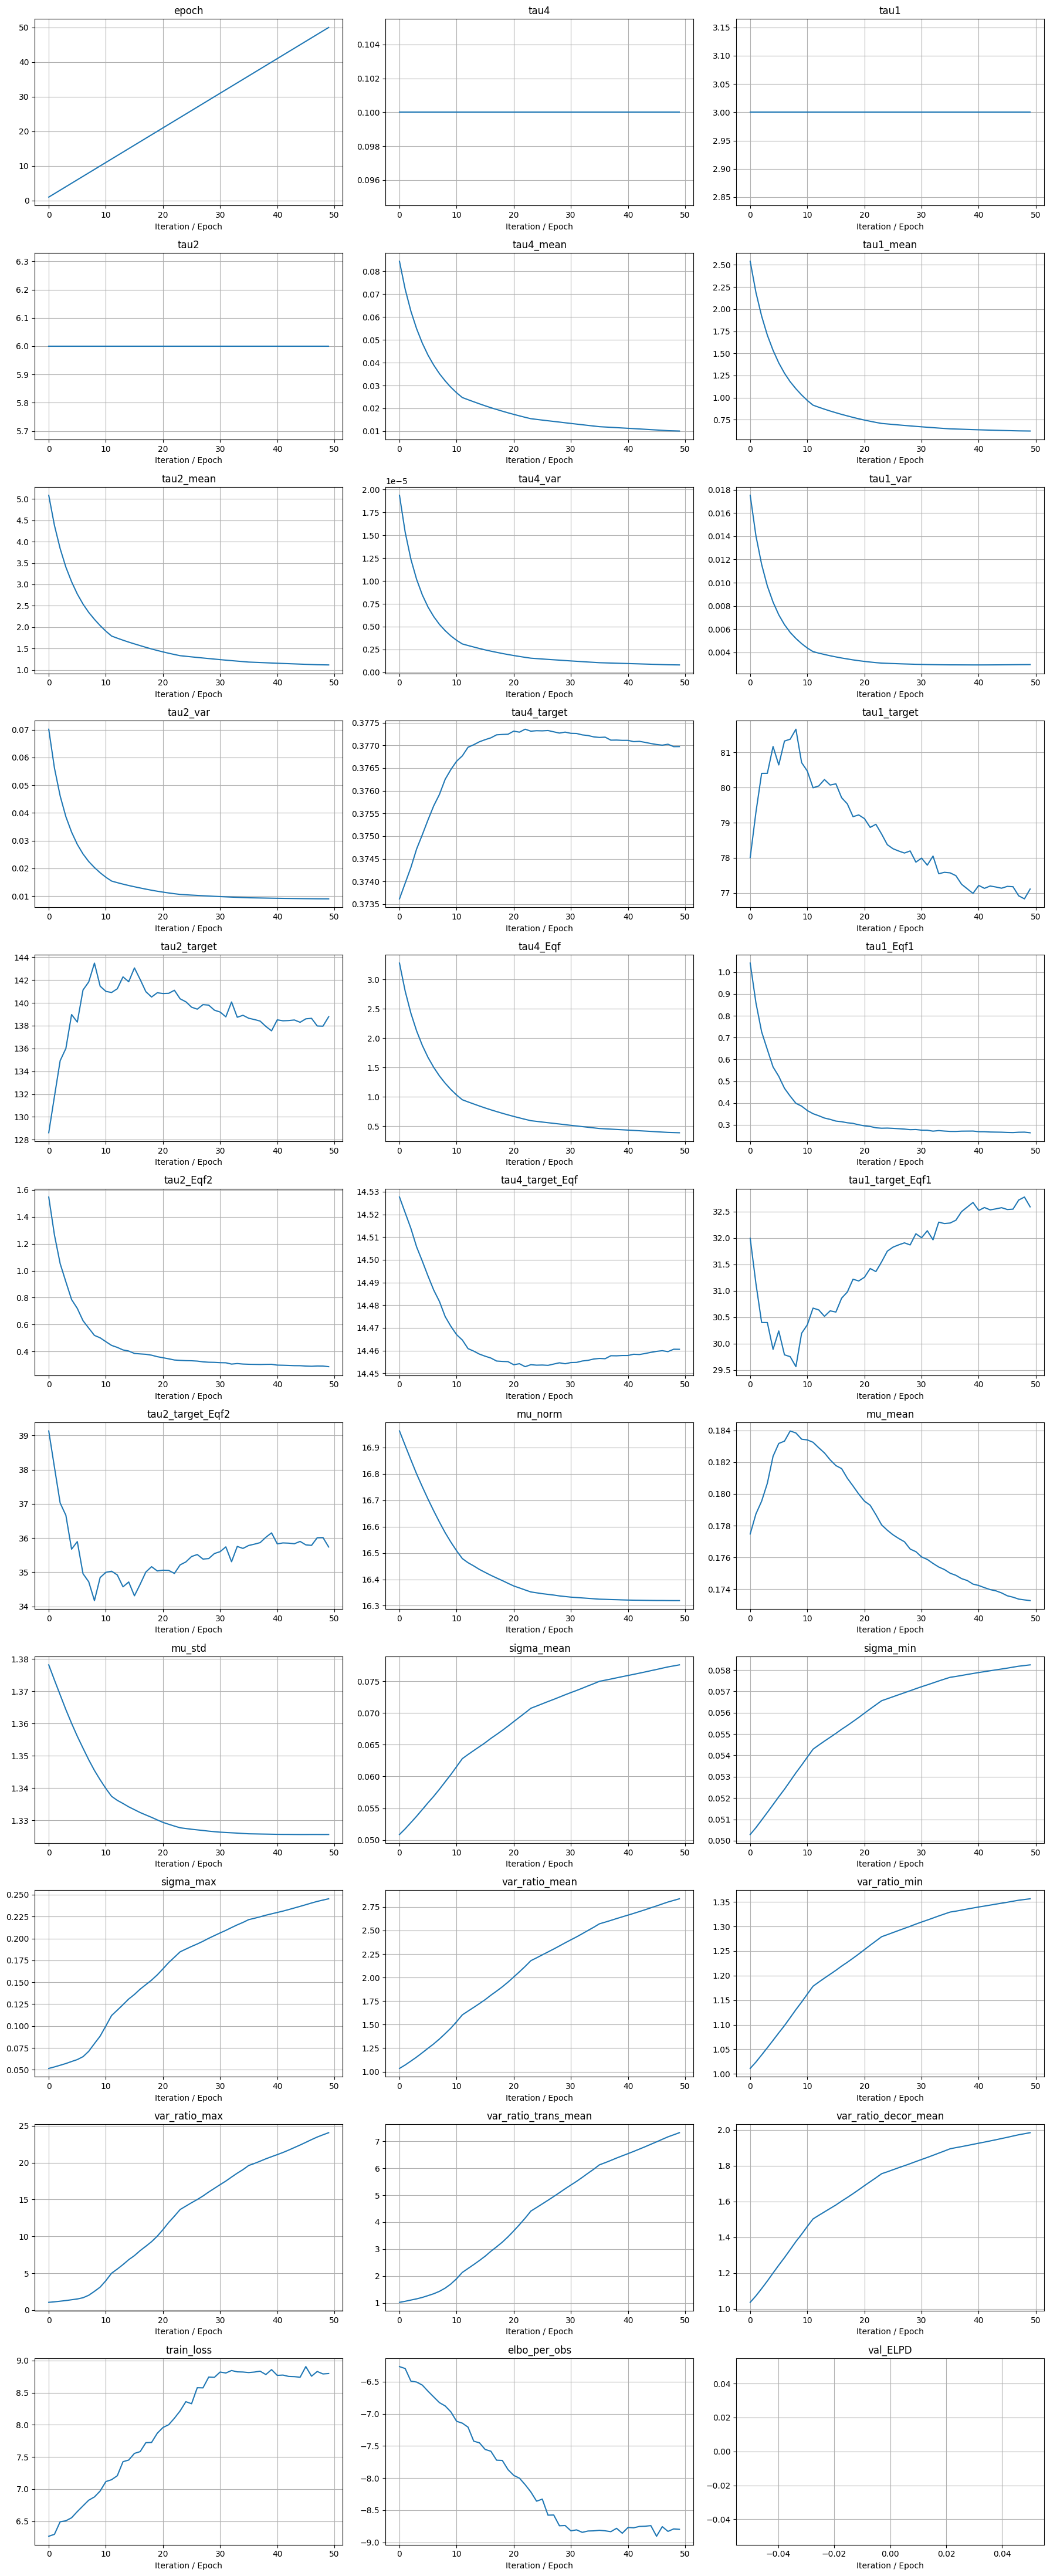

In [12]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



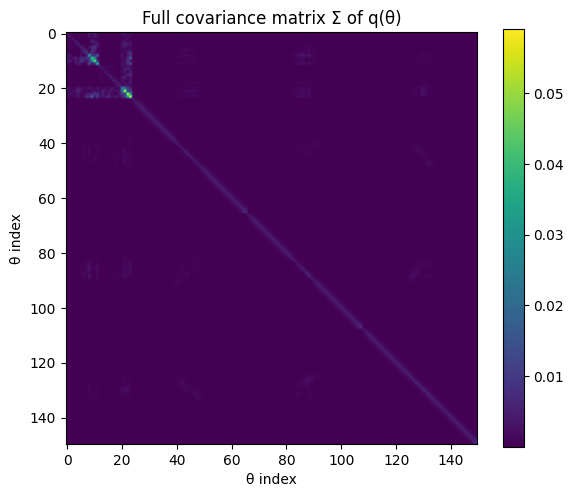

In [14]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


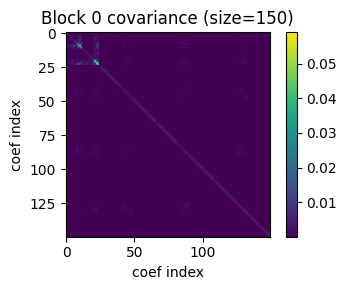

In [15]:
def plot_blocks_covariance(VI):
    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [16]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [18]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.013
KLD GTM      Train Data:  0.0286
KLD Gaussian Train Data:  0.0991
KLD Copula   Train Data:  -0.0037

KLD BGTM      Test  Data:  0.026
KLD GTM      Test  Data:  0.0372
KLD Gaussian Test  Data:  0.1136
KLD Copula   Test  Data:  0.0066


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [19]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = VI.predictive_sample(
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    n_samples=10_000,
    S=32,
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


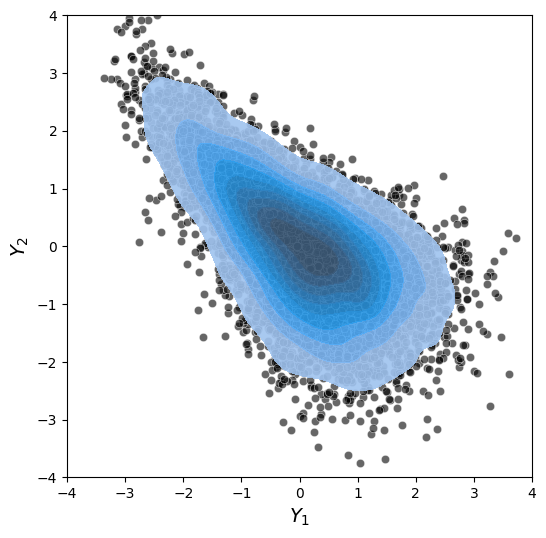

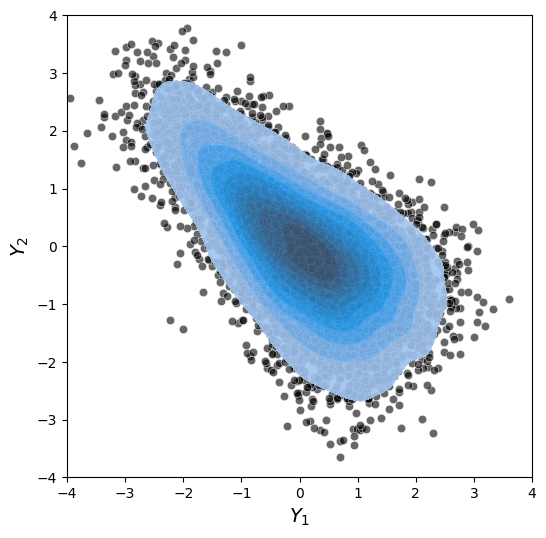

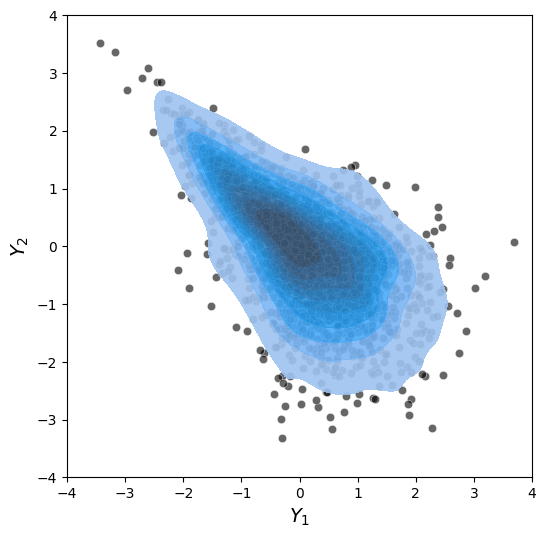

In [20]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


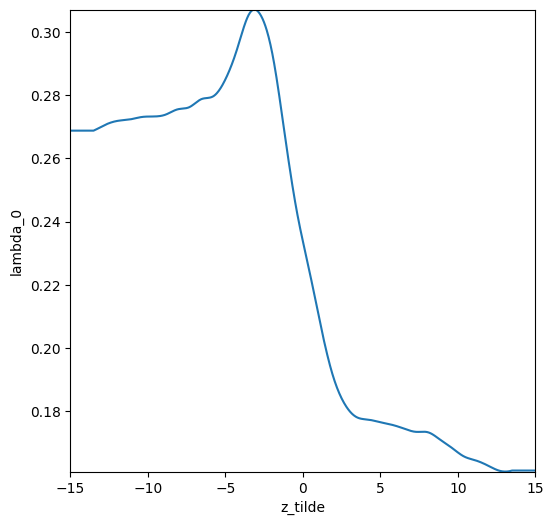

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


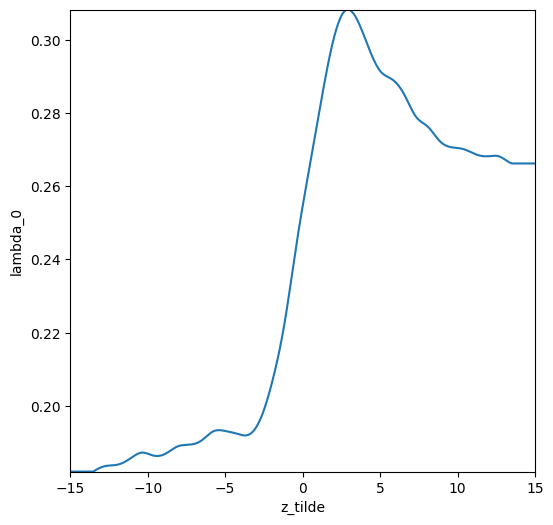

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


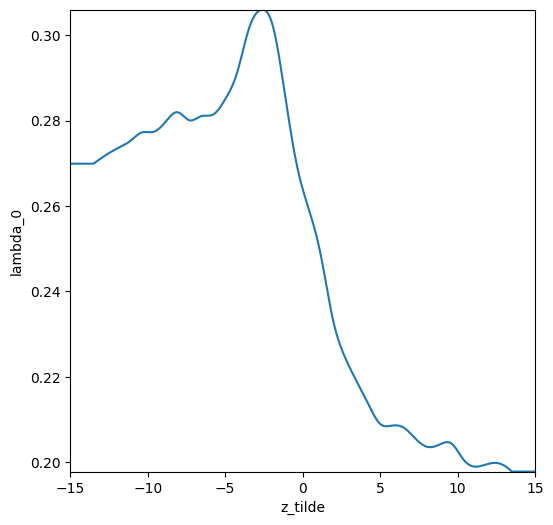

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)